# Time Series - `VAR` model

## What does `statsmodels` include?

"statsmodels" is a comprehensive Python package for statistical modeling and econometrics, offering features such as:

+ Linear regression, generalized linear models (GLM), and Bayesian regression

+ Time series models: `AR`, `MA`, `ARMA`, `ARIMA`, `SARIMA`, `SARIMAX`, `VAR`, `ARCH`, `GARCH`

+ Descriptive statistics and statistical hypothesis testing

+ Tools for autocorrelation analysis: `ACF`, `PACF`, and stationarity tests like the `Dickey-Fuller test`

# What is the `VAR` model?

## Definition:

A `VAR` **(Vector Autoregression)** model is a statistical model used to capture the linear relationships between multiple time series that influence each other over time.

Unlike univariate models (like ARIMA), VAR handles multiple interdependent time series simultaneously.

## Components:

+ **Endogenous variables**: The time series being modeled (e.g., heater sales and ice cream sales).

+ **Lagged values**: Each variable is regressed on its `own past values` and `the past values of all other variables`.

+ **Lag order** `(p)`: Number of previous time steps considered in the model.

# `ice_cream` vs `heater` data project
## Dataset description:
This project is based on a dataset originally shared by GitHub user [ritvikmath](https://github.com/ritvikmath). The data was used as the foundation for exploring a custom implementation of a `VAR` (Vector Autoregression) model and conducting time series analysis in Python.


The dataset contains monthly sales data for two seasonal products - heaters and ice creams - starting from January 2004. It consists of the following columns:

+ `Month` (string, format: YYYY-MM):

Represents the year and month of the recorded data point.

+ `heater` (integer):

The number of heaters sold in that month. Higher values are typically observed in colder months.

+ `ice cream` (integer):

The number of ice creams sold in that month. Higher values are typically observed in warmer months.

## Import the libraries:

In [293]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Read the data:

In [294]:
ice_cream_heater_df = pd.read_csv('ice_cream_vs_heater/ice_cream_vs_heater.csv')
ice_cream_heater_df.head()

,Month,heater,ice cream
0,2004-01,27,13
1,2004-02,18,15
2,2004-03,14,16
3,2004-04,13,19
4,2004-05,13,21


## Month `to_datatime()` index and `asfreq()`:

In [295]:
ice_cream_heater_df['Month'] = pd.to_datetime(ice_cream_heater_df['Month'], format='%Y-%m')
ice_cream_heater_df.set_index('Month', inplace=True)

In [296]:
ice_cream_heater_df.head()

,heater,ice cream
Month,,
2004-01-01,27,13
2004-02-01,18,15
2004-03-01,14,16
2004-04-01,13,19
2004-05-01,13,21


In [297]:
ice_cream_heater_df = ice_cream_heater_df.asfreq(freq='MS')

In [298]:
ice_cream_heater_df.head()

,heater,ice cream
Month,,
2004-01-01,27,13
2004-02-01,18,15
2004-03-01,14,16
2004-04-01,13,19
2004-05-01,13,21


In [299]:
ice_cream_heater_df.tail()

,heater,ice cream
Month,,
2020-02-01,34,45
2020-03-01,25,44
2020-04-01,25,53
2020-05-01,27,70
2020-06-01,24,74


## Visualization of the raw time series:

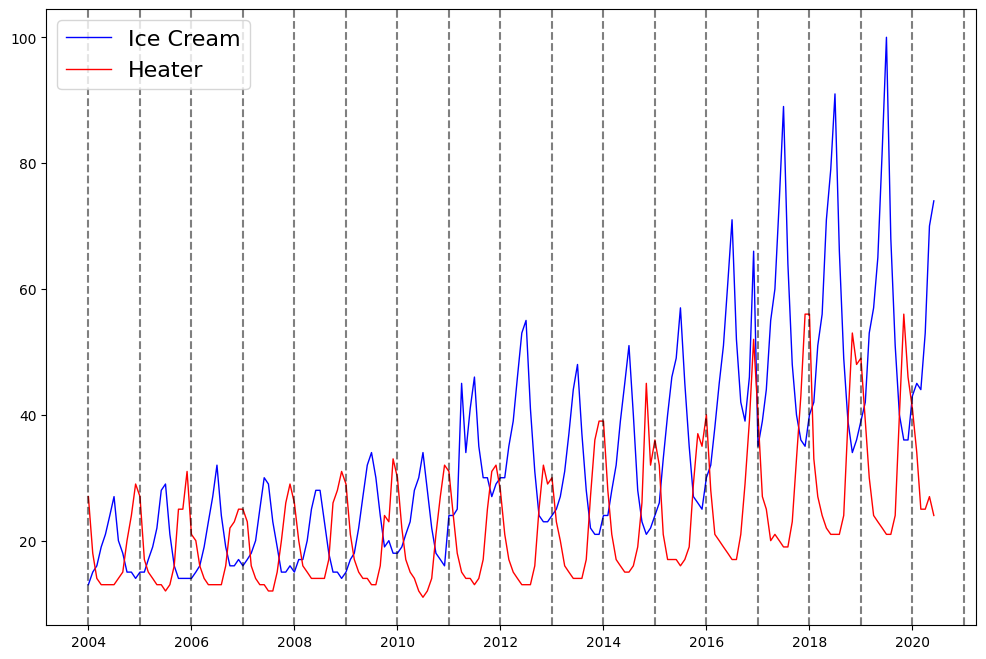

In [300]:
from datetime import datetime

start_date = pd.to_datetime('2004-01-01')
end_date = pd.to_datetime('2020-06-01')

plt.figure(figsize=(12,8))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'], color='blue', linewidth=1)
heater, = plt.plot(ice_cream_heater_df['heater'], color='red', linewidth=1)

for year in range(start_date.year, end_date.year + 2):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)

plt.legend(['Ice Cream', 'Heater'], fontsize=16)

## Data scaling:
+ VAR is based on regression coefficients, which are highly sensitive to differences in scale between variables.

+ If one variable (e.g., ice cream sales) ranges from 10 to 100, while another (e.g., heater sales) ranges from 0 to 30, the model may assign disproportionate importance to the first variable simply because its values are larger.

+ This distorts the interpretation and can lead to inaccurate results in forecasting, impact analysis, or Granger causality testing.

+ For example, we can use Z-score, IQR, or normalization

### Standardization (Z-score):
$$z = \frac{x - \mu}{\sigma}$$

+ $x$ - original value


+ $μ$ – mean


+ $σ$ – standard deviation


+ $z$ – standardized value (Z-score)


In [301]:
mean = ice_cream_heater_df.mean()
deviation = ice_cream_heater_df.std()

In [302]:
print('Mean: \n', mean)
print('\nStandard deviation: \n', deviation)

Mean: 
 heater       22.792929
ice cream    33.060606
dtype: float64

Standard deviation: 
 heater        9.795500
ice cream    17.073635
dtype: float64


In [303]:
print(mean['heater'])

22.792929292929294


In [304]:
for column in ice_cream_heater_df.columns:
    ice_cream_heater_df[column] = (ice_cream_heater_df[column] - mean[column])/deviation[column]

## Visualization of the time series after standardization:

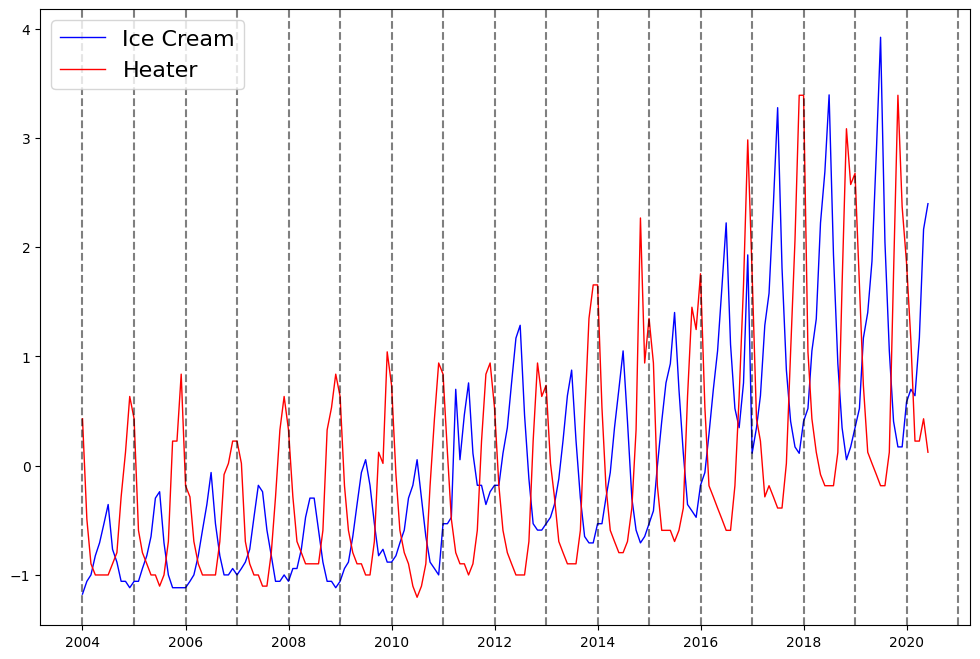

In [305]:
from datetime import datetime

start_date = pd.to_datetime('2004-01-01')
end_date = pd.to_datetime('2020-06-01')

plt.figure(figsize=(12,8))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'], color='blue', linewidth=1)
heater, = plt.plot(ice_cream_heater_df['heater'], color='red', linewidth=1)

for year in range(start_date.year, end_date.year + 2):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)

plt.legend(['Ice Cream', 'Heater'], fontsize=16)

## Is data not stationary? - ADF (Augmented Dickey-Fuller) test:

We use ADF (Augmented Dickey-Fuller) tests, which are designed to assess the stationarity of a time series.

It tests the following hypotheses:

+ H₀ (null hypothesis): the series is not stationary (contains a unit root, i.e., has a trend).

+ H₁ (alternative hypothesis): the series is stationary.

By analyzing the test statistic and the corresponding p-value, we can determine whether to reject the null hypothesis and conclude that the series is stationary.

In [306]:
from statsmodels.tsa.stattools import adfuller

results = []

for column in ice_cream_heater_df.columns:
    test_result = adfuller(ice_cream_heater_df[column])
    results.append((column, test_result[0], test_result[1]))

print("ADF Test Results:\n")

for var, adf_stat, p_val in results:
    print(f"{var:<12} | ADF Statistic: {adf_stat:.4f} | p-value: {p_val:.4f}")

ADF Test Results:

heater       | ADF Statistic: 0.9501 | p-value: 0.9937
ice cream    | ADF Statistic: -0.3039 | p-value: 0.9249


$p-value > alfa = 0.05$

We accept the null hypothesis $H_{0}$ - The series are not stationary

## Data is not stationary - `.diff().dropna()`:

In [307]:
ice_cream_heater_df = ice_cream_heater_df.diff().dropna()

## Is data not stationary? - ADF (Augmented Dickey-Fuller) hypothesis test:

We use ADF (Augmented Dickey-Fuller) tests, which are designed to assess the stationarity of a time series.

It tests the following hypotheses:

+ H₀ (null hypothesis): the series is not stationary (contains a unit root, i.e., has a trend).

+ H₁ (alternative hypothesis): the series is stationary.

By analyzing the test statistic and the corresponding p-value, we can determine whether to reject the null hypothesis and conclude that the series is stationary.

In [308]:
from statsmodels.tsa.stattools import adfuller

results = []

for column in ice_cream_heater_df.columns:
    test_result = adfuller(ice_cream_heater_df[column])
    results.append((column, test_result[0], test_result[1]))

print("ADF Test Results:\n")

for var, adf_stat, p_val in results:
    print(f"{var:<12} | ADF Statistic: {adf_stat:.5f} | p-value: {p_val:.5f}")

ADF Test Results:

heater       | ADF Statistic: -16.96731 | p-value: 0.00000
ice cream    | ADF Statistic: -4.78172 | p-value: 0.00006


$p-value < alfa = 0.05$

We reject the null hypothesis $H_{0}$ - The series are stationary

## Visualization of the time series after differencing:

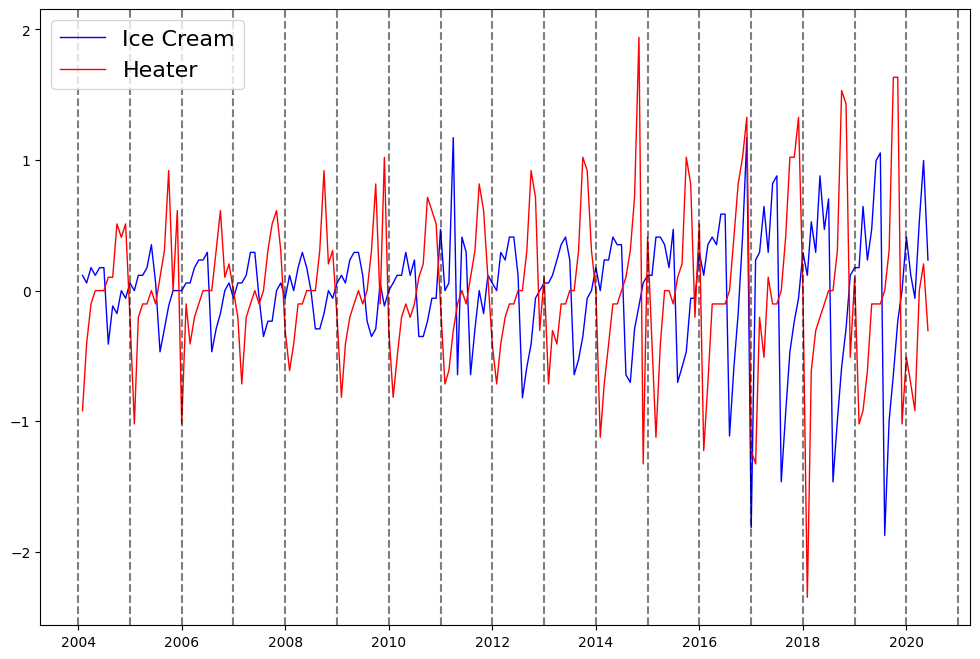

In [309]:
from datetime import datetime

start_date = pd.to_datetime('2004-01-01')
end_date = pd.to_datetime('2020-06-01')

plt.figure(figsize=(12,8))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'], color='blue', linewidth=1)
heater, = plt.plot(ice_cream_heater_df['heater'], color='red', linewidth=1)

for year in range(start_date.year, end_date.year + 2):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)

plt.legend(['Ice Cream', 'Heater'], fontsize=16)

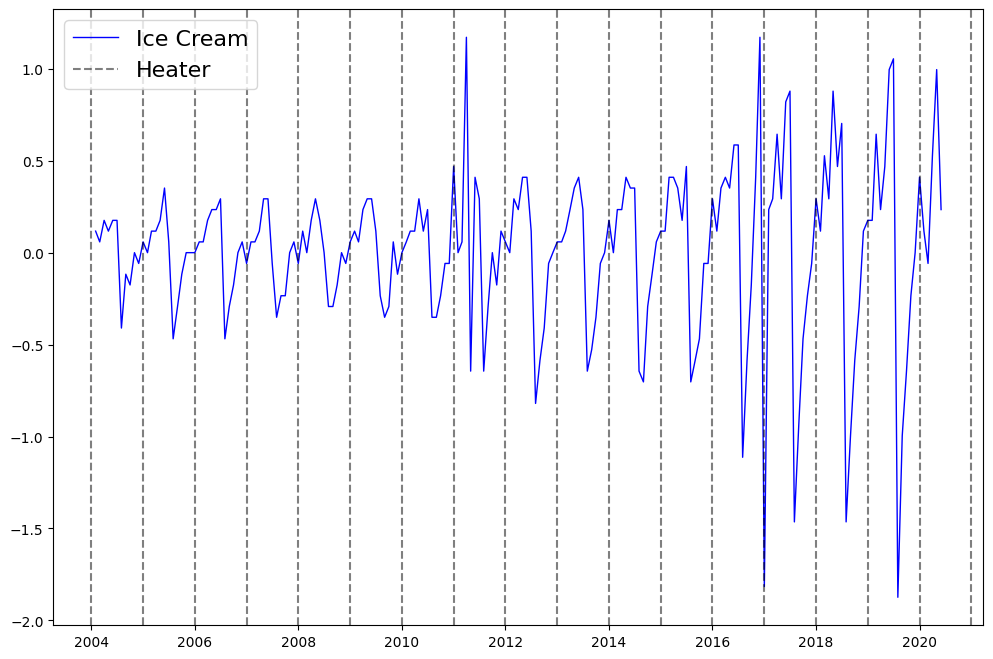

In [310]:
from datetime import datetime

start_date = pd.to_datetime('2004-01-01')
end_date = pd.to_datetime('2020-06-01')

plt.figure(figsize=(12,8))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream'], color='blue', linewidth=1)

for year in range(start_date.year, end_date.year + 2):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)

plt.legend(['Ice Cream', 'Heater'], fontsize=16)

## Remove Increasing Volatility

**Heteroscedasticity** is a situation where the variance (or spread) of the variables changes over time - in other words, the data exhibit non-constant variability. `VAR`, `ARIMA`, and regression models often assume constant error variance (homoscedasticity). When this condition is not met, the resulting forecasts may be inaccurate or misleading.
+ For example, the time series may appear calm at the beginning, but later the amplitude increases significantly - this indicates heteroscedasticity.

### Methods to address this issue:
+ **Log transformation** - useful when variance increases proportionally to the values. Data are positive.
+ **Box-Cox transformation** - helpful when the optimal transformation is not known in advance. Positive.
+ **Yeo-Johnson** - when data has negative values.
+ **Variance stabilization** - before modeling - improves residual accuracy and increases forecast reliability.


## Pre-whitening by dividing by the rolling standard deviation

In [311]:
# Calculate rolling std (window 12 months)
ice_cream_heater_df['ice_cream_rolling_std'] = (
    ice_cream_heater_df['ice cream'].rolling(window=12, min_periods=1).std()
)
ice_cream_heater_df['heater_rolling_std'] = (
    ice_cream_heater_df['heater'].rolling(window=12, min_periods=1).std()
)

# Scalling (pre-whitening)
ice_cream_heater_df['ice cream_scaled'] = (
    ice_cream_heater_df['ice cream'] / ice_cream_heater_df['ice_cream_rolling_std']
)
ice_cream_heater_df['heater_scaled'] = (
    ice_cream_heater_df['heater'] / ice_cream_heater_df['heater_rolling_std']
)

ice_cream_heater_df.head()

,heater,ice cream,ice_cream_rolling_std,heater_rolling_std,ice cream_scaled,heater_scaled
Month,,,,,,
2004-02-01,-0.918789,0.11714,NaN,NaN,NaN,NaN
2004-03-01,-0.408351,0.05857,0.041415,0.360934,1.414214,-1.131371
2004-04-01,-0.102088,0.17571,0.058570,0.412582,3.000000,-0.247436
2004-05-01,0.000000,0.11714,0.047822,0.412582,2.449490,0.000000
2004-06-01,0.000000,0.17571,0.049003,0.391410,3.585686,0.000000


## Visualization of the time series after removing heteroscedasticity:

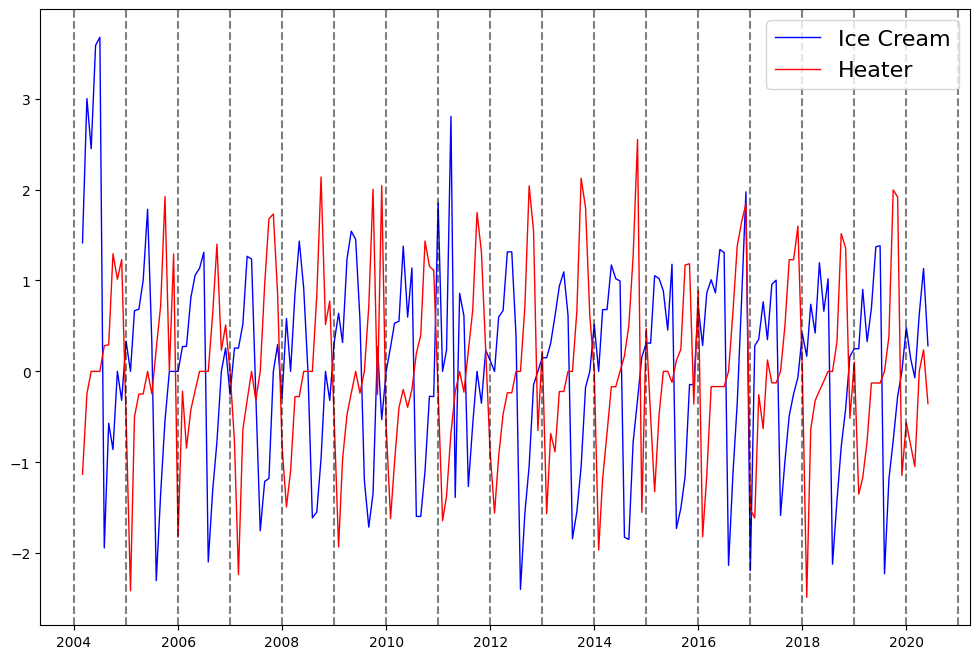

In [312]:
from datetime import datetime

start_date = pd.to_datetime('2004-01-01')
end_date = pd.to_datetime('2020-06-01')

plt.figure(figsize=(12,8))
ice_cream, = plt.plot(ice_cream_heater_df['ice cream_scaled'], color='blue', linewidth=1)
heater, = plt.plot(ice_cream_heater_df['heater_scaled'], color='red', linewidth=1)

for year in range(start_date.year, end_date.year + 2):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)

plt.legend(['Ice Cream', 'Heater'], fontsize=16)

## Breusch-Pagan hypothesis test - Is data still heteroscedasticity?

We use the Breusch-Pagan test, which is designed to assess the presence of heteroscedasticity in a time series or regression model.
It tests the following hypotheses:

+ H₀ (null hypothesis): the residuals are homoscedastic (i.e., the variance of the errors is constant over time).

+ H₁ (alternative hypothesis): the residuals are heteroscedastic (i.e., the variance of the errors changes over time).

By analyzing the test statistic and the corresponding p-value, we can determine whether to reject the null hypothesis and conclude that the residuals exhibit non-constant variance, which indicates heteroscedasticity.

In [313]:
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm

y = ice_cream_heater_df['ice cream_scaled'].dropna()
X = sm.add_constant(np.arange(len(y)))
model = sm.OLS(y, X).fit()
bp_test = het_breuschpagan(model.resid, X)
print(f"Breusch-Pagan p-value (ice cream_scaled): {bp_test[1]}")

Breusch-Pagan p-value (ice cream_scaled): 0.020912693018909655


$p-value = 0.021 < alfa = 0.02$

We reject the null hypothesis $H_{0}$ - The series is heteroscedasticity

In [314]:
from statsmodels.stats.diagnostic import het_breuschpagan

y = ice_cream_heater_df['heater_scaled'].dropna()
X = sm.add_constant(np.arange(len(y)))
model = sm.OLS(y, X).fit()
bp_test = het_breuschpagan(model.resid, X)
print(f"Breusch-Pagan p-value (heater_scaled): {bp_test[1]}")

Breusch-Pagan p-value (heater_scaled): 0.7070692886642647


$p-value = 0.71 < alfa = 0.05$

We reject the null hypothesis $H_{0}$ - The series is heteroscedasticity

## Remove seasonality

In [315]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Ustaw indeks jako datetime (jeśli jeszcze nie jest)
df = ice_cream_heater_df.copy()
df = df[['ice cream_scaled', 'heater_scaled']]

# 🔴 USUŃ NaN PO pre-whitening
df = df.dropna()

# Usuń sezonowość dla każdej zmiennej
for col in df.columns:
    decomposition = seasonal_decompose(df[col], model='additive', period=12)
    df[col + '_deseasonalized'] = df[col] - decomposition.seasonal


In [316]:
df.head()

,ice cream_scaled,heater_scaled,ice cream_scaled_deseasonalized,heater_scaled_deseasonalized
Month,,,,
2004-03-01,1.414214,-1.131371,0.929857,-0.098074
2004-04-01,3.000000,-0.247436,2.167460,0.267814
2004-05-01,2.449490,0.000000,1.568087,0.199360
2004-06-01,3.585686,0.000000,2.538606,0.116657
2004-07-01,3.674235,0.000000,2.937130,0.124811


## Visualization of the time series after removing seasonality:

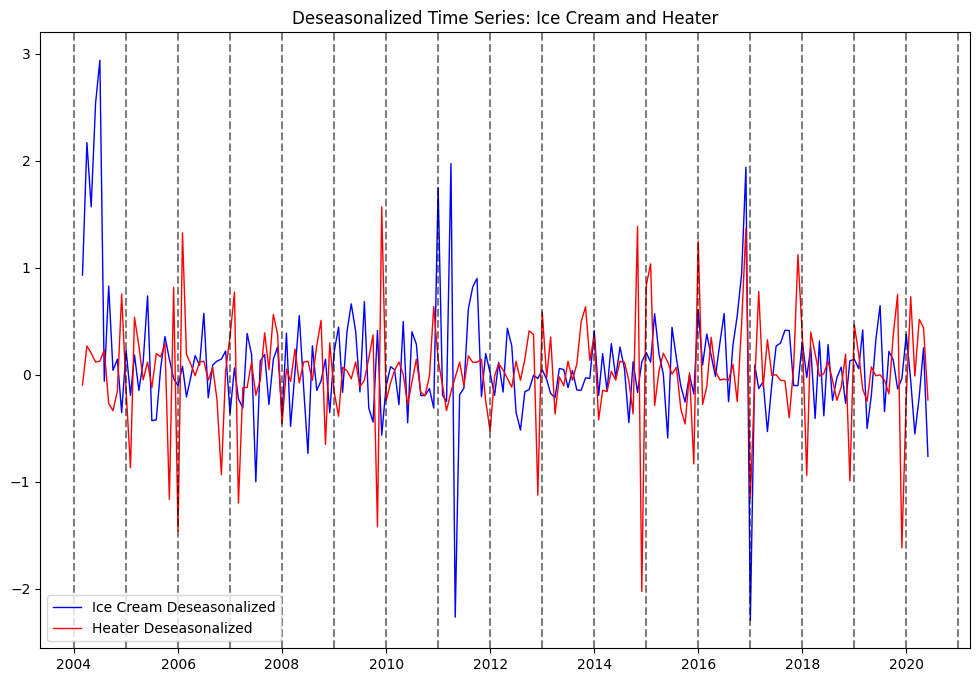

In [317]:
plt.figure(figsize=(12, 8))
plt.plot(df.index, df['ice cream_scaled_deseasonalized'], label='Ice Cream Deseasonalized', color='blue', linewidth=1)
plt.plot(df.index, df['heater_scaled_deseasonalized'], label='Heater Deseasonalized', color='red', linewidth=1)

for year in range(start_date.year, end_date.year + 2):
    plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.5)

plt.title('Deseasonalized Time Series: Ice Cream and Heater')
plt.legend()


## Canovy–Hansen hypothesis test - Is data still seasonality?
Hypotheses:

+ H₀ (null hypothesis): No seasonality present.

+ H₁ (alternative hypothesis): Seasonality is present in the data.

```python
import pandas as pd
import statsmodels.api as sm

def canova_hansen_test(series, period=12):
    # Simplified version of the Canova–Hansen seasonality test using OLS with seasonal dummies.

    # Drop missing values
    y = series.dropna()
    n = len(y)

    # Create seasonal dummy variables (e.g., months)
    seasons = pd.get_dummies(y.index.month, drop_first=True)

    # Add constant term
    X = sm.add_constant(seasons)

    # Full model with seasonal dummies
    model_full = sm.OLS(y.values, X).fit()
    rss_full = sum(model_full.resid ** 2)

    # Restricted model (intercept only)
    model_restricted = sm.OLS(
        y.values,
        sm.add_constant(pd.DataFrame(index=y.index))
    ).fit()
    rss_restricted = sum(model_restricted.resid ** 2)

    # F-statistic
    m = seasons.shape[1]
    F = ((rss_restricted - rss_full) / m) / (rss_full / (n - m - 1))
    p_value = 1 - sm.stats.f.cdf(F, m, n - m - 1)

    return F, p_value

# Apply test
f_stat_ice_cream, p_val_ice_cream = canova_hansen_test(ice_cream_heater_df['ice cream'])
f_stat_heater, p_val_heater = canova_hansen_test(ice_cream_heater_df['heater'])

# Results
print("Ice Cream: F =", f_stat_ice_cream, ", p-value =", p_val_ice_cream)
print("Heater: F =", f_stat_heater, ", p-value =", p_val_heater)
```


# PACF - Heater

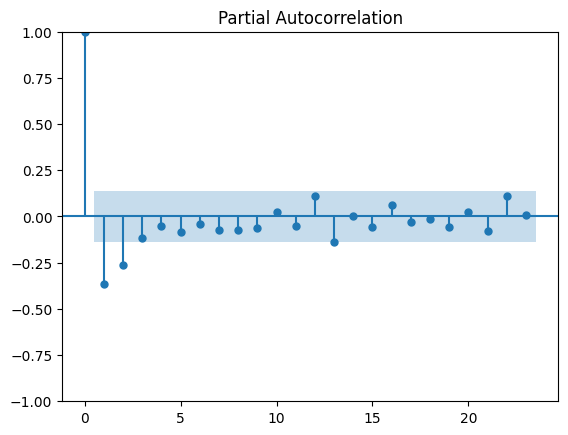

In [318]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(df['heater_scaled_deseasonalized'])
plt.show()

AR(2)

# Correlation between "heater" and lagged "ice cream"

In [319]:
from scipy.stats import pearsonr

for lag in range(1, 14):
    heater_series = df['heater_scaled_deseasonalized'].iloc[lag:]
    lagged_ice_cream_series = df['ice cream_scaled_deseasonalized'].iloc[:-lag]

    print(f'Lag: {lag}')
    corr, p_val = pearsonr(heater_series, lagged_ice_cream_series)
    print(f'Pearson correlation: {corr:.4f}, p-value: {p_val:.4f}')
    print('-------')

Lag: 1
Pearson correlation: 0.0135, p-value: 0.8518
-------
Lag: 2
Pearson correlation: -0.0557, p-value: 0.4407
-------
Lag: 3
Pearson correlation: -0.0439, p-value: 0.5441
-------
Lag: 4
Pearson correlation: 0.0350, p-value: 0.6302
-------
Lag: 5
Pearson correlation: -0.0148, p-value: 0.8387
-------
Lag: 6
Pearson correlation: 0.0126, p-value: 0.8627
-------
Lag: 7
Pearson correlation: -0.0816, p-value: 0.2644
-------
Lag: 8
Pearson correlation: 0.0920, p-value: 0.2091
-------
Lag: 9
Pearson correlation: -0.0245, p-value: 0.7388
-------
Lag: 10
Pearson correlation: 0.0003, p-value: 0.9972
-------
Lag: 11
Pearson correlation: -0.0311, p-value: 0.6740
-------
Lag: 12
Pearson correlation: -0.0357, p-value: 0.6306
-------
Lag: 13
Pearson correlation: 0.1647, p-value: 0.0259
-------


# Fit a VAR Model

In [322]:
from statsmodels.tsa.api import VAR

ice_cream_heater_df = df[['ice cream_scaled_deseasonalized', 'heater_scaled_deseasonalized']]

model = VAR(ice_cream_heater_df)
model_fit = model.fit(maxlags=13)

model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 23, Jun, 2025
Time:                     22:37:20
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.93573
Nobs:                     183.000    HQIC:                  -2.49890
Log likelihood:          -201.556    FPE:                  0.0562217
AIC:                     -2.88279    Det(Omega_mle):       0.0426941
--------------------------------------------------------------------
Results for equation ice cream_scaled_deseasonalized
                                         coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------------
const                                       0.068887         0.041259            1.670           0.095
L1.ice cream_scaled_deseasonalized         -0.240

# So our final model is:

$$
\hat{h}_t = - 0.48h_{t-1} - 0.32h_{t-2} + 0.16i_{t-13}
$$